<a href="https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/CPGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding correlated patterns in a transactional database using CP-growth

This tutorial has three parts. In the first part, we describe the basic approach to find correlated patterns in a transactional database using the CP-growth algorithm. In the second part, we describe an advanced approach, where we evaluate the performance of CP-growth algorithm on a dataset at different *minimum support* values. In the final part, we describe an advanced approach, where we evaluate the performance of CP-growth algorithm on a dataset at different *minimum all-confidence* threshold values.

***

## Prerequisites:

1. Installing the PAMI library

In [59]:
!pip install pami #install the pami repository

2. Downloading a sample dataset

In [60]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv #download a sample transactional database

File ‘Transactional_T10I4D100K.csv’ already there; not retrieving.



3. Printing few lines of a dataset to know its format.

In [61]:
!head -2 Transactional_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
39	120	124	205	401	581	704	814	825	834


_format:_ every row contains items seperated by a seperator.

__Example:__

item1 item2 item3 item4

item1 item4 item6

***



```
# This is formatted as code
```

## Part 1: Finding correlated patterns using CP-growth

### Step 1: Understanding the statistics of a database to choose an appropriate *minimum support* (*minSup*) value.

In [62]:
#import the class file
import PAMI.extras.dbStats.transactionalDatabaseStats as stats

#specify the file name
inputFile = 'Transactional_T10I4D100K.csv'

#initialize the class
obj=stats.transactionalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to derive the database statistics and plot the graphs
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the items' frequency graph and transaction length's distribution graphs for more information

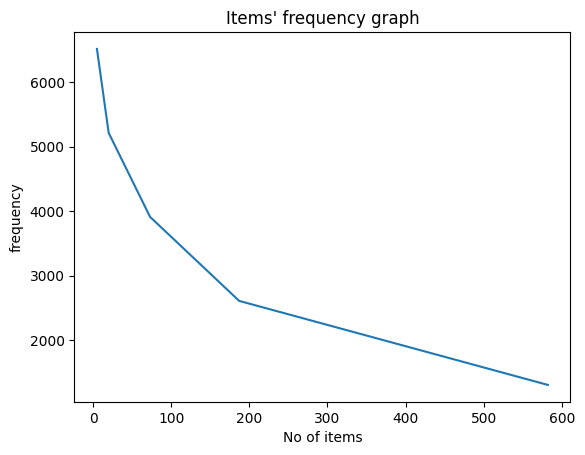

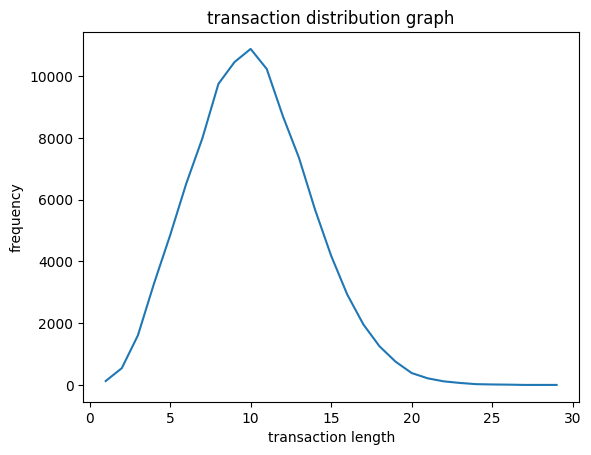

In [63]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, 100, 'Items\' frequency graph', 'No of items', 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, 100, 'transaction distribution graph', 'transaction length', 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [64]:
minSup=100 #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4: Choosing an appropriate minimum all-confidence value


We are often interested in finding patterns having high correlation. Thus, let us choose a high minAllConf value, say 0.8 (or 80%) percent.

In [65]:
minAllConf=0.2

### Step 4: Mining correlated patterns using CP-growth

In [66]:
from PAMI.correlatedPattern.basic import CPGrowth  as alg #import the algorithm

obj = alg.CPGrowth(iFile='Transactional_T10I4D100K.csv', minSup=minSup, minAllConf=minAllConf, sep='\t')    #initialize
obj.startMine()            #start the mining process

obj.save('correlatedPatternsAtMinSupCount100_020.txt') #save the patterns


correlatedPatternsDF= obj.getPatternsAsDataFrame() #get the generated correlated patterns as a dataframe
print('Total No of patterns: ' + str(len(correlatedPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))


Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Total No of patterns: 1595
Runtime: 35.86099648475647
Memory (RSS): 687165440
Memory (USS): 640770048


### Step 5: Investigating the generated patterns

Open the patterns' file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [67]:
!tail correlatedPatternsAtMinSupCount300_040.txt

561:2783:1.0 
538:3981:1.0 
448:1368:1.0 
368:7821:1.0 
328:663:1.0 
274:2626:1.0 
240:1398:1.0 
164:744:1.0 
52:1979:1.0 
25:1391:1.0 


The storage format is: _correlatedPattern:support:allConfidence_



***

## Part 2: Evaluating the CP-growth algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [68]:
#Import the libraries
from PAMI.correlatedPattern.basic import CPGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
seperator='\t'
minSupValues = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]
minAllConf=0.3

### Step 2: Create a data frame to store the results of FP-growth

In [69]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of FPGrowth algorithm

### Step 2: Create a data frame to store the results of FP-growth

In [70]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of FPGrowth algorithm

### Step 3: Execute the algorithm at different minSup values

In [71]:
for minSup in minSupValues:
    obj = alg.CPGrowth(inputFile, minSup=minSup,minAllConf=minAllConf,sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['CP-growth', minSup, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm


### Step 4: Print the result

In [72]:
print(result)

   algorithm  minSup  patterns    runtime     memory
0  CP-growth     300      1006  28.556991  679587840
1  CP-growth     300       958  31.131960  690073600
2  CP-growth     300       923  26.294015  695926784
3  CP-growth     300       883  28.402120  673914880
4  CP-growth     300       826  27.317040  702566400


### Step 5: Visualizing the results

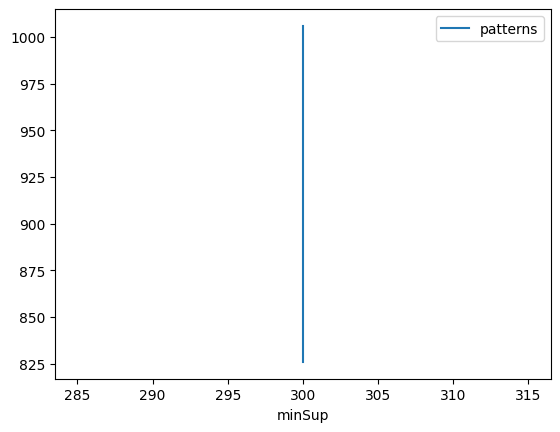

Graph for No Of Patterns is successfully generated!


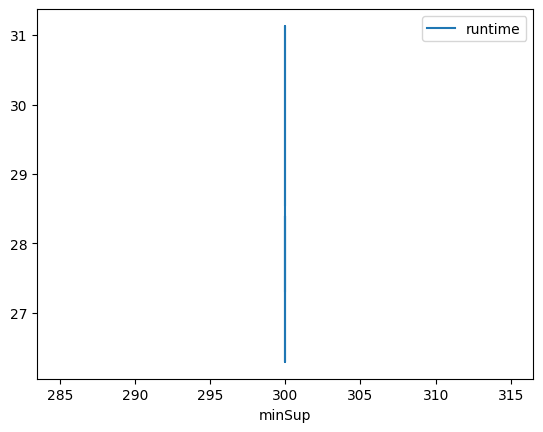

Graph for Runtime taken is successfully generated!


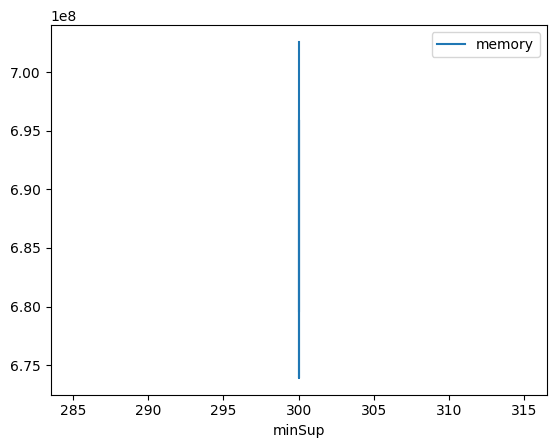

Graph for memory consumption is successfully generated!


In [73]:
from PAMI.extras.graph import plotLineGraphsFromDataFrame as plt

ab = plt.plotGraphsFromDataFrame(result)
ab.plotGraphsFromDataFrame()

***

## Part 3: Evaluating the CP-growth algorithm on a dataset at different minAllConf values

### Step 1: Import the libraries and specify the input parameters

In [74]:
#Import the libraries
from PAMI.correlatedPattern.basic import CPGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
seperator='\t'
minAllConfValues = [0.1, 0.2, 0.3, 0.4, 0.5]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]
minSup=100

### Step 2: Create a data frame to store the results of FP-growth

In [75]:
result = pd.DataFrame(columns=['algorithm', 'minAllConf', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of FPGrowth algorithm

### Step 3: Execute the algorithm at different minAllConf values

In [76]:
for minAllConf in minAllConfValues:
    obj = alg.CPGrowth(inputFile, minSup=minSupCount,minAllConf=minAllConf,sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['CP-growth', minAllConf, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm
Correlated Frequent patterns were generated successfully using CorrelatedPatternGrowth algorithm


### Step 4: Print the result

In [77]:
print(result)

   algorithm  minAllConf  patterns    runtime     memory
0  CP-growth         0.1      2951  25.665256  687943680
1  CP-growth         0.2      1209  30.526678  679116800
2  CP-growth         0.3       826  28.314394  678150144
3  CP-growth         0.4       756  24.771608  710045696
4  CP-growth         0.5       723  27.294705  681156608


### Step 5: Visualizing the results

In [78]:
from PAMI.extras.graph import plotLineGraphsFromDataFrame as plt

ab = plt.plotGraphsFromDataFrame(result)
ab.plotGraphsFromDataFrame()

KeyError: ignored